<a href="https://colab.research.google.com/github/sugi-san/BlendGAN/blob/main/BlendGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

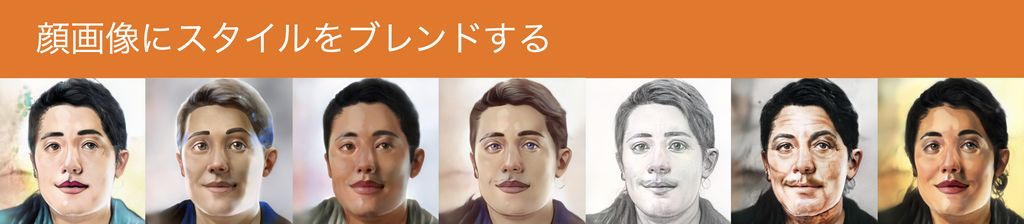

In [ ]:
#@title 1.セットアップ（３分くらい掛かります）

from IPython.utils import io
import os
import subprocess
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:

      # githubからコードを取得
      ! git clone https://github.com/sugi-san/BlendGAN.git
      %cd BlendGAN
      pbar.update(10)

      # ninjaインストール
      !wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
      !sudo unzip ninja-linux.zip -d /usr/local/bin/
      !sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force
      pbar.update(10)

      # 学習済みパラメータのダウンロード
      import gdown
      gdown.download('https://drive.google.com/uc?id=1D27HPNOSx9kWIhc13VevRy0pUv_xYiJb', './pretrained_models/blendgan.pt', quiet=False)
      gdown.download('https://drive.google.com/uc?id=1cUv_reLE6k3604or78EranS7XzuVMWeO', './pretrained_models/psp_encoder.pt', quiet=False)
      gdown.download('https://drive.google.com/uc?id=1qshfqj8SdmgQv_kfLpiohbI3QPQF-OE5', './pretrained_models/style_encoder.pt', quiet=False)
      pbar.update(60)

      # ランドマークデータのダウンロード
      ! wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
      ! bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2
      pbar.update(20)

except subprocess.CalledProcessError:
  print(captured)
  raise


# 画像の表示関数
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np

def display_pic(folder):
    fig = plt.figure(figsize=(30, 60))
    files = os.listdir(folder)
    files.sort()
    for i, file in enumerate(files):
        img = Image.open(folder+'/'+file)    
        images = np.asarray(img)
        ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])
        image_plt = np.array(images)
        ax.imshow(image_plt)
        ax.set_xlabel(file, fontsize=25)               
    plt.show()
    plt.close()


# フォルダリセット関数
import os
import shutil
def reset_folder(folder):
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.makedirs(folder, exist_ok=True)

# フォルダ作成
os.makedirs('download', exist_ok=True)

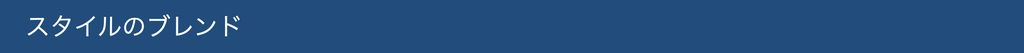

In [ ]:
#@title 2.写真の表示
display_pic('imgs/face')

In [ ]:
#@title 3.顔画像の切り出し
import os
import shutil
from tqdm import tqdm

select = 'face' #param ["face", "style"]
select_path = 'imgs/'+select
align_path = 'imgs/'+select+'_align'

reset_folder(align_path)

def run_alignment(file_path):
  import dlib
  from alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=file_path, predictor=predictor) 
  return aligned_image 


files = sorted(os.listdir(select_path))
for i, file in enumerate(tqdm(files)):
  if file=='.ipynb_checkpoints':
     continue
  input_image = run_alignment(select_path+'/'+file)
  input_image = input_image.resize((512,512))
  input_image.save(align_path+'/'+file)

display_pic(align_path)

In [ ]:
#@title 4.ブレンド（４分くらい掛かります）

#画像ファイル指定
input = "03.jpg"#@param {type:"string"}
face_path = 'imgs/face_align/'+input
style = 'wstyle' #@param ["mstyle", "wstyle"]
style_path = 'imgs/'+style
face_img_path = 'test_imgs/face_imgs'
style_img_path = 'test_imgs/style_imgs'

# フォルダーリセット
reset_folder(face_img_path)

# フォルダー削除
if os.path.isdir(style_img_path):
    shutil.rmtree(style_img_path)

# データセット
shutil.copy(face_path, face_img_path+'/'+input)  
shutil.copytree(style_path, style_img_path)

# フォルダー削除
if os.path.isdir('results/style_transfer'):
    shutil.rmtree('results/style_transfer')

# style_tranferの実行
! python style_transfer_folder.py --size 1024\
                                  --ckpt ./pretrained_models/blendgan.pt\
                                   --psp_encoder_ckpt ./pretrained_models/psp_encoder.pt\
                                   --style_img_path ./test_imgs/style_imgs/\
                                   --input_img_path ./test_imgs/face_imgs/\
                                   --outdir results/style_transfer/


# フォルダリセット
reset_folder('results/full')
reset_folder('results/face')
reset_folder('results/style')
reset_folder('results/square')

# full, face, style画像の保存
import cv2
import glob

files = glob.glob('results/style_transfer/*.jpg')
files.sort()
for i, file in enumerate(files):
    img = cv2.imread(file)
    img_resize = cv2.resize(img, dsize=(1536, 512))
    cv2.imwrite('results/full/'+str(i+1).zfill(3)+'.jpg', img_resize)  # full
    img_resize1=img_resize[0:512, 1024:1536]  
    cv2.imwrite('results/face/'+str(i+1).zfill(3)+'.jpg', img_resize1)  # face
    img_resize2=img_resize[0:512, 512:1024]  
    cv2.imwrite('results/style/'+str(i+1).zfill(3)+'.jpg', img_resize2)  # style

# square画像の保存
moto = cv2.imread('results/full/001.jpg')
moto = moto[0:512, 0:512]  # 元画像
black = cv2.imread('black.jpg') #黒画像

for i in range(len(files)):
   img1 = cv2.imread('results/style/'+str(i+1).zfill(3)+'.jpg')
   img_up = cv2.hconcat([black, img1])
   img2 = cv2.imread('results/face/'+str(i+1).zfill(3)+'.jpg')
   img_down = cv2.hconcat([moto, img2])
   img_result = cv2.vconcat([img_up, img_down])
   cv2.imwrite('results/square/'+str(i+1).zfill(3)+'.jpg', img_result)

# 画像を動画に変換
print('makeing movie...')
!ffmpeg -y -r 1 -i results/full/%3d.jpg -vcodec libx264 -pix_fmt yuv420p -loglevel error output.mp4
!ffmpeg -y -r 1 -i results/square/%3d.jpg -vcodec libx264 -pix_fmt yuv420p -loglevel error output2.mp4
print('complete!')

In [ ]:
#@title 5.動画の再生
from IPython.display import HTML
from base64 import b64encode

mp4 = open('./output.mp4', 'rb').read()
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
HTML(f"""
<video width="100%" height="100%" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")

In [ ]:
#@title 6.動画のダウンロード
import os
import shutil
from google.colab import files

#@markdown ・正方形にしたい場合は、squareにチェックを入れて下さい
square = False #@param {type:"boolean"}
if square == True:
  out_path = 'output2.mp4'
  check = 'square'
else:
  out_path = 'output.mp4'
  check ='normal'

name = os.path.splitext(input)
file_name = name[0]+'_'+style+'_'+check+'.mp4'
shutil.copy(out_path, 'download/'+file_name)
files.download('download/'+file_name)

In [ ]:
#@title 7.ブレンド画像のダウンロード
from google.colab import files

# ファイル削除
if os.path.exists('./download.zip'):
   os.remove('./download.zip')

! zip -r -q download.zip results/face

name = os.path.splitext(input)
file_name = name[0]+'_'+style+'.zip'
shutil.copy('download.zip', 'download/'+file_name)
files.download('download/'+file_name)


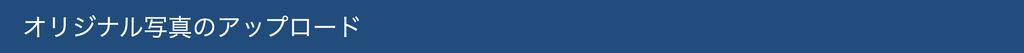

In [ ]:
#@title 8.写真のアップロード
from google.colab import files
import shutil

# ルートへ画像をアップロード
uploaded = files.upload()           
uploaded = list(uploaded.keys())    

# ルートから指定フォルダーへ移動
for file in uploaded:
    shutil.move(file, 'imgs/face/'+file)


###【備考】
・ブラウザは、必ずGoogle Chromeを使用して下さい。

・動作がおかしくなった場合の対応\
１）グーグルクロームの該当タブを削除して接続を切る\
２）再度リンクを開く\
３）右上にある「ランタイム／ランタイムを出荷時設定にリセット」をクリックする（下記写真を参照に下さい）\
４）あとは、動画にある通りの操作をすればOK

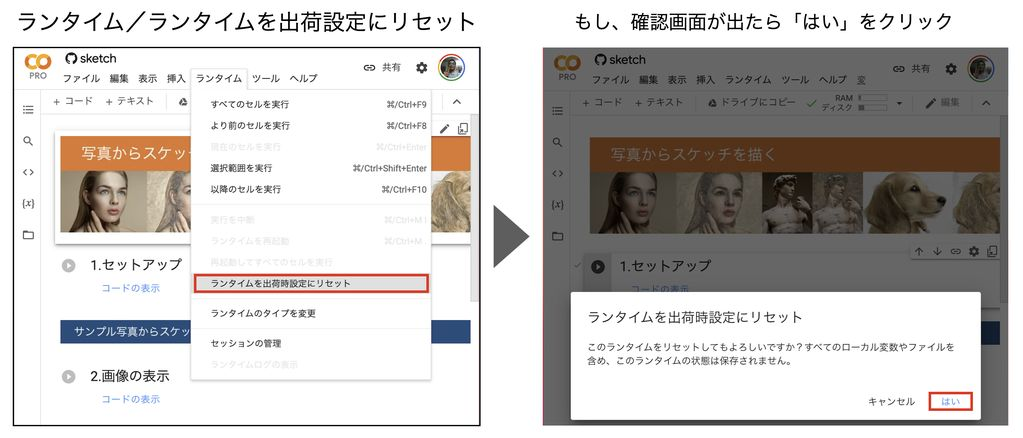